In [1]:
from dolo import *
from matplotlib import pyplot as plt
%matplotlib inline

# Chamberlain's model

Income process $y_t$ and interest rate $r_t$ are both normally distributed with:
    $$y_t = \overline{y} + \epsilon_{y,t}$$
    $$r_t = \overline{r} + \epsilon_{r,t}$$
    
The variance of $\epsilon_{y,t}$ (resp $\epsilon_{r,t}$) is $\sigma_{y}$ (resp $\sigma_{r}$).

We normalize: $\overline{y}=1$ and given discount factor $\beta$, we set $\overline{r}=\frac{1}{\beta}+\Delta r$.

The law of motion for cash-in-hand $m_t$ is:

$$m_t = y_t + (m_{t-1}-c_{t-1})r_t$$

The consumption $c_{t-1}\in]0,m_t]$ si chosen optimally so that the following Euler criterium  is zero:

$$ E_t \left[ \frac{c_{t+1}}{c_t} \beta r_{t+1}\right] - 1$$

the slackness onditions imply that this criterium is positive only if $c_t=0$ (i.e. never) or negative if $c_t=m_t$.

For any $m_{t}$ there is a level of consumption $\overline{c}_t$ such that $E_t \left[ m_{t+1} \right] = m_t$. It is defined by:

$$ c_t = m_t \left(1-\frac{1}{\overline{r}}\right) + \frac{y_t}{\overline{r}}$$

# interactive version

In [2]:
model = yaml_import('chamberlain.yaml')
drp = approximate_controls(model, eigmax=1.0001)

Model type detected as 'dtcscc'
Missing model name. Set as 'anonymous'


In [3]:
from dolo.misc.decorators import cachedondisk
def solve_calib(**calib):
    # computes
    model.set_calibration(**calib)
#     drp = approximate_controls(model, eigmax=1.0001)
    dr = time_iteration(model, initial_dr=drp, interp_type='spline',interp_orders=[20],verbose=False)
    dr = time_iteration(model, initial_dr=dr, interp_type='spline',interp_orders=[100],verbose=False,integration_orders=[10,10])
#     dr = time_iteration(model, initial_dr=dr, interp_type='spline',interp_orders=[100],verbose=False)

#     mdr = time_iteration(model, verbose=False)
#     sim = simulate(model, dr, 0)
    dsim = plot_decision_rule(model, dr, 'm',n_steps=100, bounds=(0,10))
    return [dr,dsim]
dr, dsim = solve_calib() # -> returns the consumption when m varies linearly

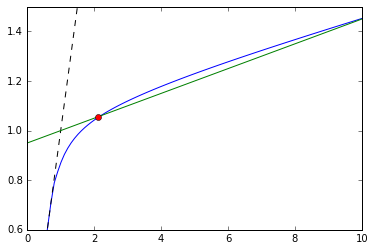

In [4]:
from ipywidgets import interact
@interact
def play_with_results(beta=(0.94,0.96,0.005),gamma=(1,8,1),delta_r=(-0.01,0.01,0.001), sigma_y=(0.0, 0.2, 0.05 ), sigma_r=(0.0, 0.05, 0.005 )):

    [dr,dsim] = solve_calib(delta_r=delta_r, beta=beta, gamma=gamma, sigma_r=sigma_r, sigma_y=sigma_y)

    plt.plot(dsim['m'], dsim['c'])
    plt.plot(dsim['m'], dsim['m'], color='black', linestyle='--')
    plt.ylim(0.6,1.5)
    r = model.get_calibration('r')
    y = 1
    noacc = dsim['m']-(dsim['m']-y)/r
    plt.plot(dsim['m'],noacc, color='green')
    # find intersection points
    d = numpy.array(dsim['c'] - noacc)
    inds = numpy.where( (d[1:]*d[:-1])<0 )[0]
    for i in inds:
        plt.plot(dsim['m'][i], noacc[i],'o', color='red')
# "hint: try delta_r <0"

# manual version

In [5]:
# import the model
model = yaml_import('chamberlain.yaml')

Model type detected as 'dtcscc'
Missing model name. Set as 'anonymous'


In [6]:
# set calibration
model.set_calibration(beta=0.95, gamma=4, delta_r=-0.001, sigma_y=0.1, sigma_r=0.025)

In [7]:
# solve the model
drp = approximate_controls(model, eigmax=1.0001)  # perturbation solution
dr0 = time_iteration(model, initial_dr=drp, interp_type='spline',verbose=False)
# increase number of quadrature to make solution smoother
# increase number of interpolation points also
dr = time_iteration(model, initial_dr=dr0, interp_type='spline', verbose=True,
                    integration_orders=[10,10], interp_orders=[100])

Using bounds specified by model
Starting time iteration
------------------------------------------------
| N   |  Error     | Gain     | Time     | nit |
------------------------------------------------
|   1 |  2.000e-01 |    0.200 |    0.214 |  10 |
|   2 |  1.145e-01 |    0.573 |    0.122 |   7 |
|   3 |  6.810e-02 |    0.595 |    0.089 |   5 |
|   4 |  4.248e-02 |    0.624 |    0.074 |   4 |
|   5 |  2.894e-02 |    0.681 |    0.102 |   5 |
|   6 |  2.081e-02 |    0.719 |    0.074 |   4 |
|   7 |  1.543e-02 |    0.741 |    0.071 |   4 |
|   8 |  1.174e-02 |    0.761 |    0.078 |   5 |
|   9 |  9.154e-03 |    0.779 |    0.077 |   5 |
|  10 |  7.270e-03 |    0.794 |    0.071 |   4 |
|  11 |  5.866e-03 |    0.807 |    0.063 |   4 |
|  12 |  4.807e-03 |    0.820 |    0.063 |   4 |
|  13 |  3.982e-03 |    0.828 |    0.050 |   3 |
|  14 |  3.328e-03 |    0.836 |    0.048 |   3 |
|  15 |  2.805e-03 |    0.843 |    0.048 |   3 |
|  16 |  2.387e-03 |    0.851 |    0.048 |   3 |
|  17 |  2.04

    Did not converge


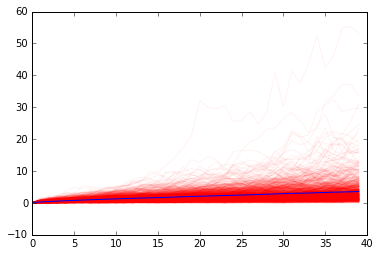

In [8]:
import pandas
sim = simulate(model, dr,n_exp=1000)
sim = pandas.Panel(sim.swapaxes(0,1), minor_axis=model.variables)
for i in range(sim.shape[0]):
    plt.plot(sim[i]['a'], color='red', alpha=0.05)
plt.plot(sim.mean(axis=0)['a'])

(0.6, 1.5)

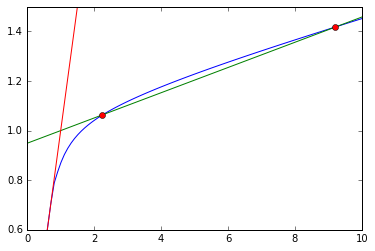

In [9]:
y,r = model.get_calibration(['y','r'])
sim = plot_decision_rule(model,dr,'m',n_steps=100)
plt.plot(sim['m'],sim['c'])
noacc = sim['m']-(sim['m']-y)/r
plt.plot(sim['m'],noacc)
plt.plot(sim['m'],sim['m'])
# find intersection points
d = numpy.array(sim['c'] - noacc)
inds = numpy.where( (d[1:]*d[:-1])<0 )[0]
for i in inds:
    plt.plot(sim['m'][i], noacc[i],'o', color='red')
# plt.ylim(0.9,1.1)
plt.ylim(0.6,1.5)
